In [56]:
import scipy.io
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Loading the data

In [57]:
data_path = "./data/"

ARDS_data = scipy.io.loadmat(data_path + "Ards.mat")
Control_data = scipy.io.loadmat(data_path + "Control.mat")

ARDS_data = {key: ARDS_data[key][0] for key in ["P", "Q", "V", "t"]}
Control_data = {key: Control_data[key][0] for key in ["P", "Q", "V", "t"]}

# Part 1 : make plots of the differents curves

In [58]:
def plot_time_curve(X, Y, t, alpha_value = 0.5, x_label = "X", y_label ="Y", grid = True, title = "Time curve", x_lim=None, y_lim=None, line = False):
    # Create a colormap that represents the gradient of time
    cmap = plt.cm.jet  # You can choose any colormap you prefer
    norm = plt.Normalize(min(t), max(t))
    ncolors = len(t)  # Number of colors should match the number of time points
    colors = cmap(norm(t))

    # Create a list of segments for the LineCollection
    points = np.array([X, Y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a LineCollection object with a color gradient
    lc = LineCollection(segments, cmap=ListedColormap(colors), norm=BoundaryNorm(t, ncolors), linewidth=2, alpha=alpha_value)
    lc.set_array(t)

    minX = np.argmin(X)
    maxX = np.argmax(X)



    # Plot the trajectory
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.colorbar(lc, label='Time')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if line:
        ax.plot([X[minX], X[maxX]],  [Y[minX], Y[maxX]])
    if grid:
        plt.grid()
    if x_lim is not None:
        plt.xlim(x_lim)
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.show()

def plot_time_curves_patient(data, title="Data"):
    P = data['P']
    V = data['V']
    Q = data['Q']
    t = data['t'] - data['t'][0]

    plot_time_curve(P, V, t, title = title + " P-V curve", x_label="P [cmH2O]", y_label="V [l]" , line = True, grid=True, x_lim=[-0.5, 45], y_lim=[-0.05, 0.35])
    plot_time_curve(V, Q, t, title = title + " V-Q curve", x_label="V [l]", y_label="Q [l/s]", grid=True, y_lim=[-0.9, 0.6], x_lim=[-0.05, 0.35])

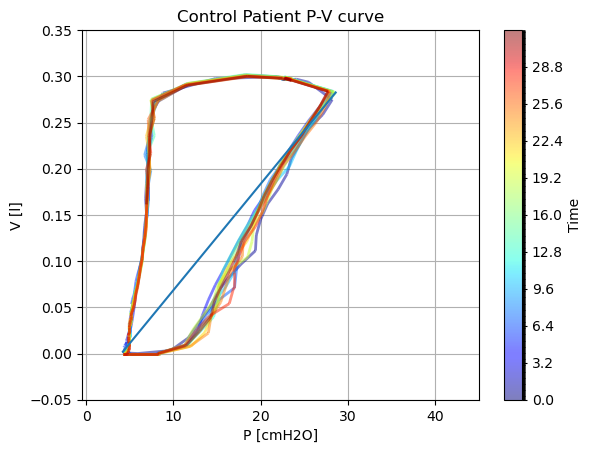

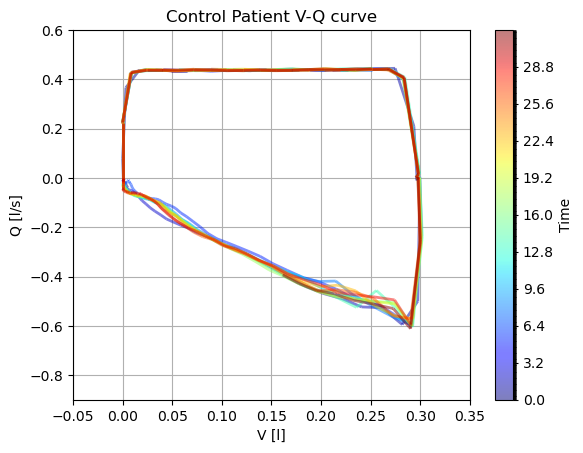

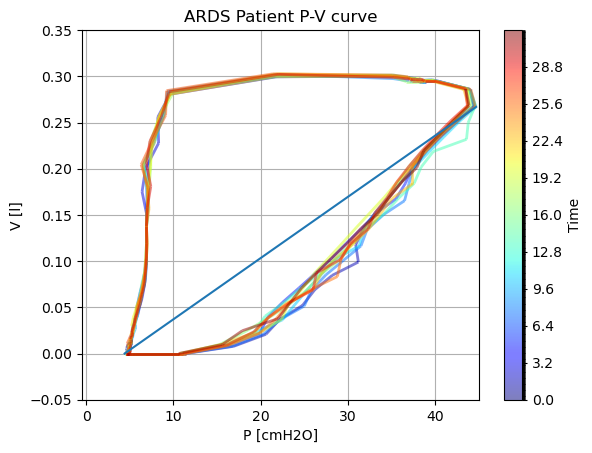

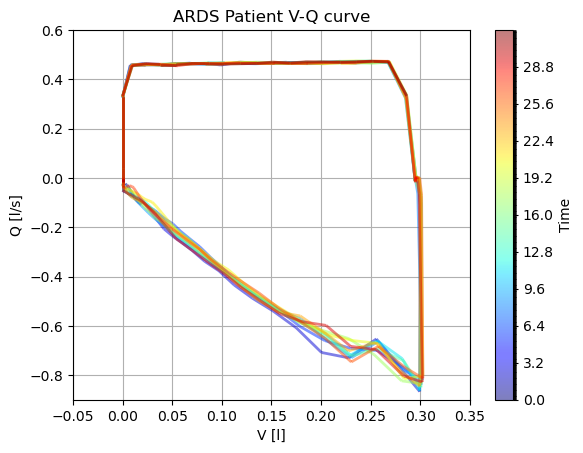

In [59]:
plot_time_curves_patient(Control_data, "Control Patient")
plot_time_curves_patient(ARDS_data, "ARDS Patient")

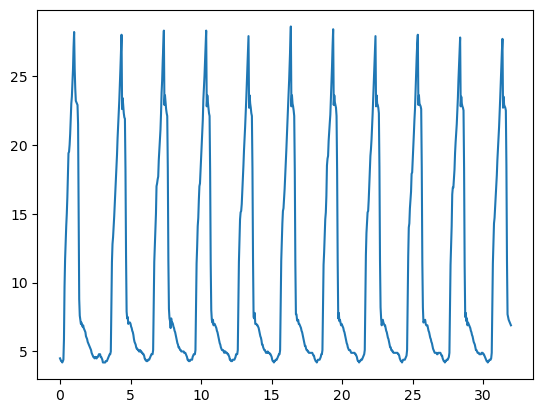

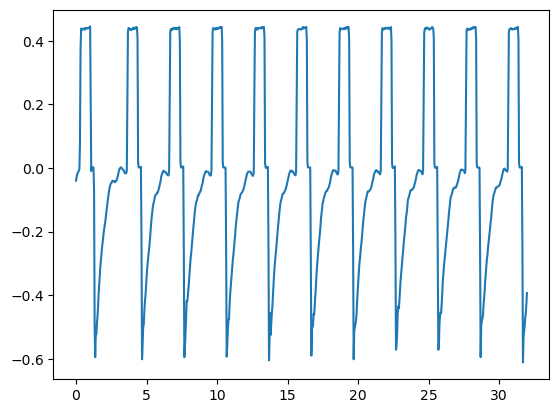

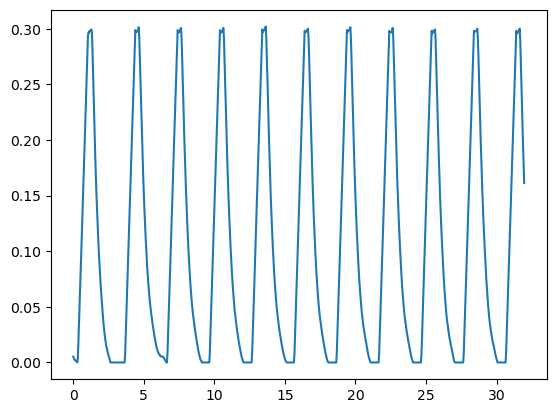

In [60]:
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['P'], label="Control data")
plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['Q'], label="Control data")

plt.figure()
plt.plot(Control_data['t'] - Control_data['t'][0], Control_data['V'], label="Control data")

In [61]:
def extract_cycles(data):
    cycles = []

    t = data['t']
    P = data['P']
    Q = data['Q']
    V = data['V']

    zero_V_indices = np.argwhere(V == 0).flatten()
    filtered_V_indices = []

    if len(zero_V_indices) == 0:
        print("Not a proper curve ! Never cross V = 0")
        exit(-1)

    filtered_V_indices.append(zero_V_indices[0])

    for i in range(1, len(zero_V_indices)):
        if zero_V_indices[i] != zero_V_indices[i-1] + 1:
            filtered_V_indices.append(zero_V_indices[i])

    for i in range(0, len(filtered_V_indices) - 1):
        cycles.append({'t' : t[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'P' : P[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'Q' : Q[filtered_V_indices[i]:filtered_V_indices[i+1]+1],
                       'V' : V[filtered_V_indices[i]:filtered_V_indices[i+1]+1]})

    return cycles
"""
for c, d in enumerate(extract_cycles(Control_data)):

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'xticks': [], 'yticks': []})

    # Plot on each subplot
    for ax, data_type in zip(axs, ['V', 'P', 'Q']):
        ax.plot(d['t'], d[data_type])
        ax.set_title(data_type)

    plt.suptitle(f"Cycle {c + 1}", y=1.05)
    plt.tight_layout()
    plt.show()

    plot_time_curves_patient(d, f"Control Patient - Cycle {c+1} - ")
"""
    

'\nfor c, d in enumerate(extract_cycles(Control_data)):\n\n    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={\'xticks\': [], \'yticks\': []})\n\n    # Plot on each subplot\n    for ax, data_type in zip(axs, [\'V\', \'P\', \'Q\']):\n        ax.plot(d[\'t\'], d[data_type])\n        ax.set_title(data_type)\n\n    plt.suptitle(f"Cycle {c + 1}", y=1.05)\n    plt.tight_layout()\n    plt.show()\n\n    plot_time_curves_patient(d, f"Control Patient - Cycle {c+1} - ")\n'

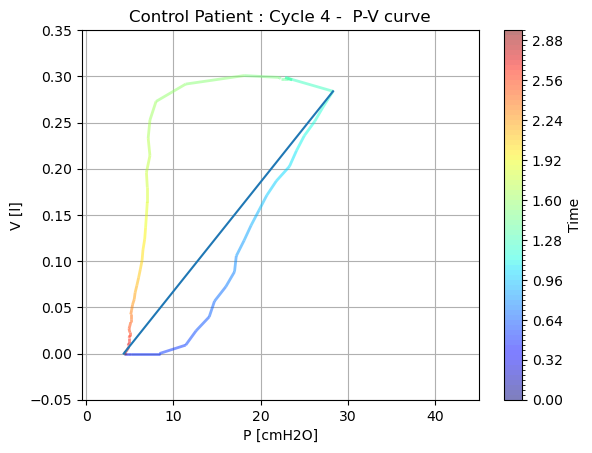

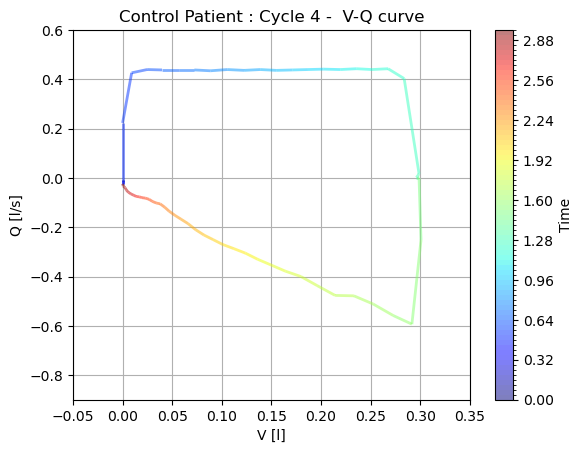

43.10607


In [68]:
d = extract_cycles(Control_data)[3]
plot_time_curves_patient(d, "Control Patient : Cycle 4 - ")

WOB = np.trapz(Control_data['P'], Control_data['V'])
print(WOB)
X = Control_data['P']
Y = Control_data['V']


In [63]:
def model(t, Ers, V, Rrs, Q, P0):
    return Ers*V(t) + Rrs * Q(t) + P0

from scipy.interpolate import interp1d

def from_data_get_interpolate(data):
    t = data['t']
    V = data['V']
    P = data['P']
    Q = data['Q']

    t_span = [min(t), max(t)]

    V_interp = interp1d(t, V, kind='linear', fill_value='extrapolate')
    P_interp = interp1d(t, P, kind='linear', fill_value='extrapolate')
    Q_interp = interp1d(t, Q, kind='linear', fill_value='extrapolate')

    return t_span, V_interp, P_interp, Q_interp

from sklearn.linear_model import LinearRegression

def estimate_parameters(data):
    V = data['V']
    P = data['P']
    Q = data['Q']

    X = np.array([V, Q]).T
    Y = np.array(P)

    model = LinearRegression().fit(X, Y)
    
    Ers = model.coef_[0]
    Rrs = model.coef_[1]
    P0 = model.intercept_

    R_squared = model.score(X, Y)

    return Ers, Rrs, P0, R_squared

for c, d in enumerate(extract_cycles(Control_data)):
    print(estimate_parameters(d))

(56.7978670894796, 16.996224171241035, 4.784966626420895, 0.983901493721375)
(54.55530966927519, 16.36911626679554, 4.582626436130704, 0.986343601706908)
(55.17887988408583, 16.86603140048803, 4.732617185354286, 0.98330815885553)
(55.29745006930847, 16.969692082624306, 4.78075950654266, 0.9872013920768457)
(54.456829914428226, 16.36059629963115, 4.741177183370318, 0.9835563136953273)
(55.179033670354464, 16.66514291294531, 4.777242780419215, 0.9846248439148108)
(55.334075748304755, 16.711740786183963, 4.731776144096108, 0.9841337578319366)
(54.667011848308235, 16.776013164341876, 4.781164869957458, 0.9847524911562605)
(55.35467914837881, 17.0699591932944, 4.8588224452546624, 0.9852896342697766)
(54.54345145025657, 17.057618328916284, 4.859576052940456, 0.9827665109135536)
